In [1]:
import tensorflow as tf

tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 200
num_node = 14300
num_var = 4

n_epochs = 500000
batch_size = 10
LR =1e-4
Lv1_latent_dim = 128
epoch_1 = 15000

alpha = 0

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[2,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[3,0:num_node,:]=data.values[0:num_node,:]
del(data)



# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 2000)
(14300, 2000)
(14300, 2000)
(14300, 2000)
(4, 14300, 2000)
2000


In [11]:
# validate
data_save.shape

(4, 14300, 2000)

In [12]:
data_save[0,:,0]

array([-6.89786095e-02, -1.12475000e-04, -5.79693520e-02, ...,
        9.36027045e-05,  9.64131082e-05,  1.26859516e-04])

In [13]:
x_axis = np.linspace(0,num_node,num_node)

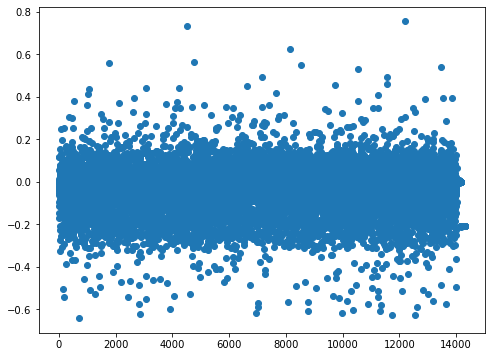

In [14]:
plt.scatter(x_axis, data[1,:,0])

In [15]:
data

array([[[-6.89786095e-02, -6.90686095e-02, -6.91686095e-02, ...,
          5.94513905e-02,  5.53013905e-02,  5.10313905e-02],
        [-1.12475000e-04, -1.12475000e-04, -1.12475000e-04, ...,
          1.17525000e-04,  1.17525000e-04,  1.17525000e-04],
        [-5.79693520e-02, -6.00293520e-02, -6.18193520e-02, ...,
         -2.53593520e-02, -1.98793520e-02, -1.32493520e-02],
        ...,
        [ 9.36027045e-05,  9.78147045e-05,  1.01694705e-04, ...,
         -3.08229295e-04, -2.99705295e-04, -3.16787295e-04],
        [ 9.64131082e-05,  1.00752108e-04,  1.04748108e-04, ...,
         -3.17483892e-04, -3.08703892e-04, -3.26297892e-04],
        [ 1.26859516e-04,  1.32568516e-04,  1.37827516e-04, ...,
         -4.17743484e-04, -4.06191484e-04, -4.29341484e-04]],

       [[ 1.14076923e-01,  1.08896723e-01,  1.04070523e-01, ...,
          1.46918123e-01,  1.55649123e-01,  1.64449123e-01],
        [ 4.07609774e-04,  4.17334774e-04,  4.25319774e-04, ...,
         -1.26194523e-03, -1.26030523e

## FOM data type : FOM_data = np.array[param, time, node, var]

In [16]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 200, 14300, 4)

In [17]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

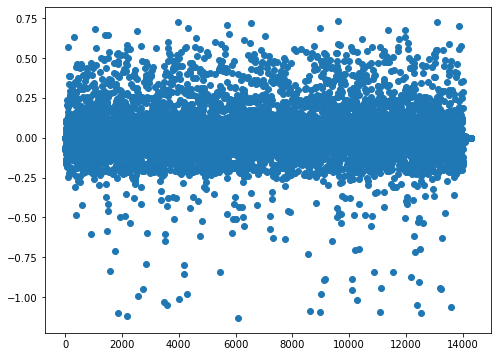

In [18]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [19]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0689786094999989
-0.053598609499999
-0.069068609499999
-0.0579693519999993


In [20]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [21]:
print(maximum)
print(minimum)
print(mean)
print(AT)

1.975119874
-2.98124239376
-1.687812283097838e-17
4.95636226776


In [22]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [23]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.39850191880599645
-0.6014980811940035


In [24]:
FOM_data.shape

(10, 200, 14300, 4)

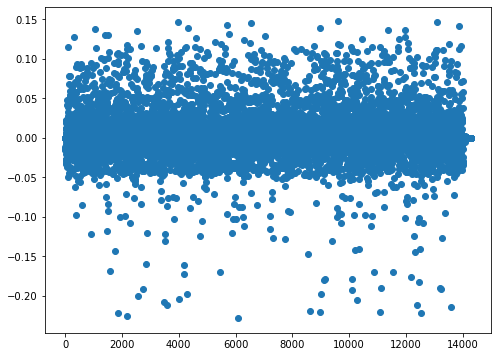

In [25]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [26]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(2000, 14300, 4)

In [27]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [28]:
Lv1_input_shape = Lv1_input.shape[1:]

In [29]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(2000, 14300, 4)
(14300, 4)


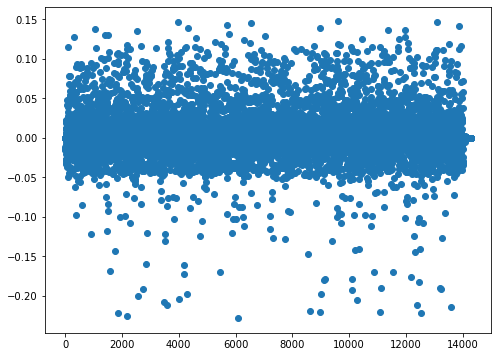

In [30]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Encoder

In [31]:
def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv1_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 4)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 14304, 4)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14304, 256)        5376      
_________________________________________________________________
batch_normalization (BatchNo (None, 14304, 256)        1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14304, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14304, 256)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14304, 128)        1639

# Decoder

In [32]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)

128
14300


In [33]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(Lv1_input_shape_decoder*Lv1_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv1_input_shape_decoder,Lv1_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    z=layers.Dense(num_var)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14300, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0   

# loss computation

In [34]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    
    loss = reconstruction_error
    
    return loss

# VAE

In [35]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [36]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%5000==0):
            if((epoch+1)%5000==0):          
                filename1 = 'test_constrained_ae/decoder_%d.h5' % (epoch+1)
                filename2 = 'test_constrained_ae/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [37]:
print(Lv1_input.shape)
print(type(Lv1_input))

(2000, 14300, 4)
<class 'numpy.ndarray'>


# Warm up

In [38]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/500000
200/200 [==============================] - 23s 87ms/step - loss: 0.2923
Epoch 2/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0879
Epoch 3/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0682
Epoch 4/500000
200/200 [==============================] - 18s 88ms/step - loss: 0.0547
Epoch 5/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0444
Epoch 6/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0361
Epoch 7/500000
200/200 [==============================] - 18s 88ms/step - loss: 0.0302
Epoch 8/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0243
Epoch 9/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0196
Epoch 10/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0152
Epoch 11/500000
200/200 [==============================] - 17s 87ms/step - loss: 0.0117
Epoch 12/500000
200/200 [================

200/200 [==============================] - 18s 88ms/step - loss: 3.4310e-05
Epoch 177/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.4674e-05
Epoch 178/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.3437e-05
Epoch 179/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.3624e-05
Epoch 180/500000
200/200 [==============================] - 17s 87ms/step - loss: 3.3851e-05
Epoch 181/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.3388e-05
Epoch 182/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.4646e-05
Epoch 183/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.4074e-05
Epoch 184/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.3261e-05
Epoch 185/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.3784e-05
Epoch 186/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.416

200/200 [==============================] - 17s 87ms/step - loss: 3.0665e-05
Epoch 353/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.0833e-05
Epoch 354/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.1014e-05
Epoch 355/500000
200/200 [==============================] - 17s 87ms/step - loss: 3.1166e-05
Epoch 356/500000
200/200 [==============================] - 17s 87ms/step - loss: 3.0533e-05
Epoch 357/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.0501e-05
Epoch 358/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.0630e-05
Epoch 359/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.1023e-05
Epoch 360/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.0594e-05
Epoch 361/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.0225e-05
Epoch 362/500000
200/200 [==============================] - 18s 88ms/step - loss: 3.025

200/200 [==============================] - 18s 88ms/step - loss: 2.9471e-05
Epoch 529/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9180e-05
Epoch 530/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9400e-05
Epoch 531/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9046e-05
Epoch 532/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9238e-05
Epoch 533/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9550e-05
Epoch 534/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9153e-05
Epoch 535/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9567e-05
Epoch 536/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.9728e-05
Epoch 537/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8926e-05
Epoch 538/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.948

200/200 [==============================] - 18s 88ms/step - loss: 2.9007e-05
Epoch 705/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8377e-05
Epoch 706/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8776e-05
Epoch 707/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7556e-05
Epoch 708/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8245e-05
Epoch 709/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8514e-05
Epoch 710/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8292e-05
Epoch 711/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8174e-05
Epoch 712/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8441e-05
Epoch 713/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8608e-05
Epoch 714/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.805

200/200 [==============================] - 18s 88ms/step - loss: 2.8375e-05
Epoch 881/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7518e-05
Epoch 882/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7765e-05
Epoch 883/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7755e-05
Epoch 884/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7537e-05
Epoch 885/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7469e-05
Epoch 886/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.8043e-05
Epoch 887/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7516e-05
Epoch 888/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7572e-05
Epoch 889/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7818e-05
Epoch 890/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.744

200/200 [==============================] - 17s 87ms/step - loss: 2.7112e-05
Epoch 1056/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7381e-05
Epoch 1057/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7624e-05
Epoch 1058/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7526e-05
Epoch 1059/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7372e-05
Epoch 1060/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7100e-05
Epoch 1061/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7277e-05
Epoch 1062/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7155e-05
Epoch 1063/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7126e-05
Epoch 1064/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.7594e-05
Epoch 1065/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.7080e-05
Epoch 1230/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7276e-05
Epoch 1231/500000
200/200 [==============================] - 18s 89ms/step - loss: 2.6923e-05
Epoch 1232/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6290e-05
Epoch 1233/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6693e-05
Epoch 1234/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6912e-05
Epoch 1235/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7707e-05
Epoch 1236/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6858e-05
Epoch 1237/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6493e-05
Epoch 1238/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6920e-05
Epoch 1239/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 89ms/step - loss: 2.6643e-05
Epoch 1404/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7036e-05
Epoch 1405/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6746e-05
Epoch 1406/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.7203e-05
Epoch 1407/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6176e-05
Epoch 1408/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6222e-05
Epoch 1409/500000
200/200 [==============================] - 18s 89ms/step - loss: 2.6355e-05
Epoch 1410/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6643e-05
Epoch 1411/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6558e-05
Epoch 1412/500000
200/200 [==============================] - 18s 89ms/step - loss: 2.6617e-05
Epoch 1413/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.6134e-05
Epoch 1578/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6784e-05
Epoch 1579/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6157e-05
Epoch 1580/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6092e-05
Epoch 1581/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6303e-05
Epoch 1582/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6138e-05
Epoch 1583/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6437e-05
Epoch 1584/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6093e-05
Epoch 1585/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6723e-05
Epoch 1586/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6064e-05
Epoch 1587/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.6359e-05
Epoch 1752/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6312e-05
Epoch 1753/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6135e-05
Epoch 1754/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5979e-05
Epoch 1755/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6341e-05
Epoch 1756/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5876e-05
Epoch 1757/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5870e-05
Epoch 1758/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5927e-05
Epoch 1759/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5944e-05
Epoch 1760/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.6073e-05
Epoch 1761/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.6313e-05
Epoch 1926/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6128e-05
Epoch 1927/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5711e-05
Epoch 1928/500000
200/200 [==============================] - 18s 89ms/step - loss: 2.6403e-05
Epoch 1929/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6133e-05
Epoch 1930/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5923e-05
Epoch 1931/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6064e-05
Epoch 1932/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5918e-05
Epoch 1933/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6041e-05
Epoch 1934/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5762e-05
Epoch 1935/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.6001e-05
Epoch 2100/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5636e-05
Epoch 2101/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5765e-05
Epoch 2102/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5449e-05
Epoch 2103/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6104e-05
Epoch 2104/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5774e-05
Epoch 2105/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5729e-05
Epoch 2106/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5542e-05
Epoch 2107/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5451e-05
Epoch 2108/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6023e-05
Epoch 2109/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.5533e-05
Epoch 2274/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6020e-05
Epoch 2275/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5748e-05
Epoch 2276/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5739e-05
Epoch 2277/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5800e-05
Epoch 2278/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.6016e-05
Epoch 2279/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5166e-05
Epoch 2280/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5155e-05
Epoch 2281/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5170e-05
Epoch 2282/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5862e-05
Epoch 2283/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.5089e-05
Epoch 2448/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5320e-05
Epoch 2449/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5763e-05
Epoch 2450/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5705e-05
Epoch 2451/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5270e-05
Epoch 2452/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5436e-05
Epoch 2453/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5464e-05
Epoch 2454/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5250e-05
Epoch 2455/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5699e-05
Epoch 2456/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5443e-05
Epoch 2457/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5657e-05
Epoch 2622/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5313e-05
Epoch 2623/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5225e-05
Epoch 2624/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5750e-05
Epoch 2625/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5605e-05
Epoch 2626/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5328e-05
Epoch 2627/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5952e-05
Epoch 2628/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5427e-05
Epoch 2629/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5511e-05
Epoch 2630/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5482e-05
Epoch 2631/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.5025e-05
Epoch 2796/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5506e-05
Epoch 2797/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5419e-05
Epoch 2798/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5334e-05
Epoch 2799/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5888e-05
Epoch 2800/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5271e-05
Epoch 2801/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5254e-05
Epoch 2802/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5432e-05
Epoch 2803/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5483e-05
Epoch 2804/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5097e-05
Epoch 2805/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5099e-05
Epoch 2970/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5179e-05
Epoch 2971/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5068e-05
Epoch 2972/500000
200/200 [==============================] - 18s 87ms/step - loss: 2.5541e-05
Epoch 2973/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5384e-05
Epoch 2974/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5744e-05
Epoch 2975/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5510e-05
Epoch 2976/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5041e-05
Epoch 2977/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5087e-05
Epoch 2978/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5158e-05
Epoch 2979/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5385e-05
Epoch 3144/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5285e-05
Epoch 3145/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5098e-05
Epoch 3146/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5082e-05
Epoch 3147/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5153e-05
Epoch 3148/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5249e-05
Epoch 3149/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5085e-05
Epoch 3150/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4813e-05
Epoch 3151/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5386e-05
Epoch 3152/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5129e-05
Epoch 3153/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5338e-05
Epoch 3318/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5216e-05
Epoch 3319/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5161e-05
Epoch 3320/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4872e-05
Epoch 3321/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5655e-05
Epoch 3322/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5379e-05
Epoch 3323/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5170e-05
Epoch 3324/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5149e-05
Epoch 3325/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5192e-05
Epoch 3326/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5140e-05
Epoch 3327/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5113e-05
Epoch 3492/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4833e-05
Epoch 3493/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5337e-05
Epoch 3494/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4702e-05
Epoch 3495/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4994e-05
Epoch 3496/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5034e-05
Epoch 3497/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5835e-05
Epoch 3498/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5160e-05
Epoch 3499/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5370e-05
Epoch 3500/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5639e-05
Epoch 3501/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5350e-05
Epoch 3666/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4962e-05
Epoch 3667/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5039e-05
Epoch 3668/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5054e-05
Epoch 3669/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4966e-05
Epoch 3670/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5455e-05
Epoch 3671/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4834e-05
Epoch 3672/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5546e-05
Epoch 3673/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4829e-05
Epoch 3674/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5047e-05
Epoch 3675/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4983e-05
Epoch 3840/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4744e-05
Epoch 3841/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5166e-05
Epoch 3842/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5418e-05
Epoch 3843/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4940e-05
Epoch 3844/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4598e-05
Epoch 3845/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5009e-05
Epoch 3846/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.4626e-05
Epoch 3847/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5191e-05
Epoch 3848/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5134e-05
Epoch 3849/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4926e-05
Epoch 4014/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4540e-05
Epoch 4015/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5288e-05
Epoch 4016/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4648e-05
Epoch 4017/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4626e-05
Epoch 4018/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4914e-05
Epoch 4019/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4842e-05
Epoch 4020/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4780e-05
Epoch 4021/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4839e-05
Epoch 4022/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4907e-05
Epoch 4023/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.5102e-05
Epoch 4188/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5018e-05
Epoch 4189/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4801e-05
Epoch 4190/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5010e-05
Epoch 4191/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4680e-05
Epoch 4192/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4822e-05
Epoch 4193/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5199e-05
Epoch 4194/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4964e-05
Epoch 4195/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4679e-05
Epoch 4196/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5419e-05
Epoch 4197/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4911e-05
Epoch 4362/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4577e-05
Epoch 4363/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4757e-05
Epoch 4364/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5000e-05
Epoch 4365/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4761e-05
Epoch 4366/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4749e-05
Epoch 4367/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5266e-05
Epoch 4368/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4725e-05
Epoch 4369/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4886e-05
Epoch 4370/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4699e-05
Epoch 4371/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4811e-05
Epoch 4536/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5025e-05
Epoch 4537/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5206e-05
Epoch 4538/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4868e-05
Epoch 4539/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4834e-05
Epoch 4540/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5121e-05
Epoch 4541/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4778e-05
Epoch 4542/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4891e-05
Epoch 4543/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4817e-05
Epoch 4544/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4664e-05
Epoch 4545/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.5130e-05
Epoch 4710/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5102e-05
Epoch 4711/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5028e-05
Epoch 4712/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4773e-05
Epoch 4713/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4490e-05
Epoch 4714/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4787e-05
Epoch 4715/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5221e-05
Epoch 4716/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4828e-05
Epoch 4717/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4529e-05
Epoch 4718/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4564e-05
Epoch 4719/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4492e-05
Epoch 4884/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5026e-05
Epoch 4885/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4799e-05
Epoch 4886/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5101e-05
Epoch 4887/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4582e-05
Epoch 4888/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4740e-05
Epoch 4889/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4587e-05
Epoch 4890/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4170e-05
Epoch 4891/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4815e-05
Epoch 4892/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4956e-05
Epoch 4893/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4727e-05
Epoch 5054/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4936e-05
Epoch 5055/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4955e-05
Epoch 5056/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4850e-05
Epoch 5057/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4768e-05
Epoch 5058/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4629e-05
Epoch 5059/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4566e-05
Epoch 5060/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4727e-05
Epoch 5061/500000
200/200 [==============================] - 18s 87ms/step - loss: 2.4518e-05
Epoch 5062/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4738e-05
Epoch 5063/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4448e-05
Epoch 5228/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4251e-05
Epoch 5229/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4723e-05
Epoch 5230/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4830e-05
Epoch 5231/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4601e-05
Epoch 5232/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4724e-05
Epoch 5233/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4984e-05
Epoch 5234/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4784e-05
Epoch 5235/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4773e-05
Epoch 5236/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4706e-05
Epoch 5237/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4788e-05
Epoch 5402/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5255e-05
Epoch 5403/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4698e-05
Epoch 5404/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4536e-05
Epoch 5405/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4660e-05
Epoch 5406/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4689e-05
Epoch 5407/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4814e-05
Epoch 5408/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4667e-05
Epoch 5409/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4666e-05
Epoch 5410/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4378e-05
Epoch 5411/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4810e-05
Epoch 5576/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4481e-05
Epoch 5577/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4470e-05
Epoch 5578/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4894e-05
Epoch 5579/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4806e-05
Epoch 5580/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4915e-05
Epoch 5581/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4468e-05
Epoch 5582/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4801e-05
Epoch 5583/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5037e-05
Epoch 5584/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4720e-05
Epoch 5585/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4620e-05
Epoch 5750/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4805e-05
Epoch 5751/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4597e-05
Epoch 5752/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5113e-05
Epoch 5753/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4548e-05
Epoch 5754/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4380e-05
Epoch 5755/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4266e-05
Epoch 5756/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4623e-05
Epoch 5757/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4390e-05
Epoch 5758/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4779e-05
Epoch 5759/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4688e-05
Epoch 5924/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4531e-05
Epoch 5925/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4490e-05
Epoch 5926/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4310e-05
Epoch 5927/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4674e-05
Epoch 5928/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4772e-05
Epoch 5929/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4768e-05
Epoch 5930/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4860e-05
Epoch 5931/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4436e-05
Epoch 5932/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4722e-05
Epoch 5933/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 87ms/step - loss: 2.4814e-05
Epoch 6098/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4519e-05
Epoch 6099/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4532e-05
Epoch 6100/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4713e-05
Epoch 6101/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4816e-05
Epoch 6102/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4703e-05
Epoch 6103/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4424e-05
Epoch 6104/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4453e-05
Epoch 6105/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4341e-05
Epoch 6106/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4893e-05
Epoch 6107/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4536e-05
Epoch 6272/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4690e-05
Epoch 6273/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4818e-05
Epoch 6274/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4859e-05
Epoch 6275/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.5043e-05
Epoch 6276/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4746e-05
Epoch 6277/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4655e-05
Epoch 6278/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4441e-05
Epoch 6279/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4672e-05
Epoch 6280/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4328e-05
Epoch 6281/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4980e-05
Epoch 6446/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4414e-05
Epoch 6447/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4735e-05
Epoch 6448/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3896e-05
Epoch 6449/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4522e-05
Epoch 6450/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5028e-05
Epoch 6451/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4668e-05
Epoch 6452/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4191e-05
Epoch 6453/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4182e-05
Epoch 6454/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4759e-05
Epoch 6455/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4473e-05
Epoch 6620/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4531e-05
Epoch 6621/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4316e-05
Epoch 6622/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4603e-05
Epoch 6623/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4365e-05
Epoch 6624/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4647e-05
Epoch 6625/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4716e-05
Epoch 6626/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4699e-05
Epoch 6627/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4467e-05
Epoch 6628/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4663e-05
Epoch 6629/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4670e-05
Epoch 6794/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4846e-05
Epoch 6795/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4095e-05
Epoch 6796/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4906e-05
Epoch 6797/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4475e-05
Epoch 6798/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4739e-05
Epoch 6799/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4414e-05
Epoch 6800/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4423e-05
Epoch 6801/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4460e-05
Epoch 6802/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4005e-05
Epoch 6803/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4447e-05
Epoch 6968/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4195e-05
Epoch 6969/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4515e-05
Epoch 6970/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4639e-05
Epoch 6971/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4310e-05
Epoch 6972/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.5010e-05
Epoch 6973/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4481e-05
Epoch 6974/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4687e-05
Epoch 6975/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4698e-05
Epoch 6976/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4544e-05
Epoch 6977/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 25s 123ms/step - loss: 2.4432e-05
Epoch 7141/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.3981e-05
Epoch 7142/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4508e-05
Epoch 7143/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4724e-05
Epoch 7144/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4189e-05
Epoch 7145/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4418e-05
Epoch 7146/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4673e-05
Epoch 7147/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4024e-05
Epoch 7148/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4250e-05
Epoch 7149/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4456e-05
Epoch 7150/500000
200/200 [==============================] - 25s 123

200/200 [==============================] - 25s 126ms/step - loss: 2.4375e-05
Epoch 7313/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4360e-05
Epoch 7314/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4200e-05
Epoch 7315/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4286e-05
Epoch 7316/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4420e-05
Epoch 7317/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4170e-05
Epoch 7318/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4450e-05
Epoch 7319/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4282e-05
Epoch 7320/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4326e-05
Epoch 7321/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4392e-05
Epoch 7322/500000
200/200 [==============================] - 25s 127

200/200 [==============================] - 25s 125ms/step - loss: 2.4071e-05
Epoch 7485/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4489e-05
Epoch 7486/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4464e-05
Epoch 7487/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4029e-05
Epoch 7488/500000
200/200 [==============================] - 25s 126ms/step - loss: 2.4524e-05
Epoch 7489/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4118e-05
Epoch 7490/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4479e-05
Epoch 7491/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4275e-05
Epoch 7492/500000
200/200 [==============================] - 24s 120ms/step - loss: 2.4340e-05
Epoch 7493/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4393e-05
Epoch 7494/500000
200/200 [==============================] - 20s 102

200/200 [==============================] - 18s 88ms/step - loss: 2.4025e-05
Epoch 7658/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4556e-05
Epoch 7659/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4306e-05
Epoch 7660/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4230e-05
Epoch 7661/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4291e-05
Epoch 7662/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4720e-05
Epoch 7663/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4082e-05
Epoch 7664/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4314e-05
Epoch 7665/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4330e-05
Epoch 7666/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3890e-05
Epoch 7667/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4535e-05
Epoch 7832/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4495e-05
Epoch 7833/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4684e-05
Epoch 7834/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4598e-05
Epoch 7835/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4370e-05
Epoch 7836/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4505e-05
Epoch 7837/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4203e-05
Epoch 7838/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4517e-05
Epoch 7839/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4930e-05
Epoch 7840/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4408e-05
Epoch 7841/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4433e-05
Epoch 8006/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4169e-05
Epoch 8007/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4340e-05
Epoch 8008/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4501e-05
Epoch 8009/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4038e-05
Epoch 8010/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4440e-05
Epoch 8011/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4748e-05
Epoch 8012/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4275e-05
Epoch 8013/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4719e-05
Epoch 8014/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4394e-05
Epoch 8015/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.3977e-05
Epoch 8180/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4229e-05
Epoch 8181/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4073e-05
Epoch 8182/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4477e-05
Epoch 8183/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4483e-05
Epoch 8184/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4191e-05
Epoch 8185/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4348e-05
Epoch 8186/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4050e-05
Epoch 8187/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4426e-05
Epoch 8188/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4413e-05
Epoch 8189/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4309e-05
Epoch 8354/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3884e-05
Epoch 8355/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4482e-05
Epoch 8356/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4633e-05
Epoch 8357/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4283e-05
Epoch 8358/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3981e-05
Epoch 8359/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4129e-05
Epoch 8360/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4261e-05
Epoch 8361/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4363e-05
Epoch 8362/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4765e-05
Epoch 8363/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4422e-05
Epoch 8528/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4393e-05
Epoch 8529/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4377e-05
Epoch 8530/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4572e-05
Epoch 8531/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3762e-05
Epoch 8532/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4746e-05
Epoch 8533/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4288e-05
Epoch 8534/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4074e-05
Epoch 8535/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4592e-05
Epoch 8536/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4281e-05
Epoch 8537/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4294e-05
Epoch 8702/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4570e-05
Epoch 8703/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4412e-05
Epoch 8704/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4328e-05
Epoch 8705/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4117e-05
Epoch 8706/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4473e-05
Epoch 8707/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4430e-05
Epoch 8708/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4211e-05
Epoch 8709/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4388e-05
Epoch 8710/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4224e-05
Epoch 8711/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4476e-05
Epoch 8876/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4584e-05
Epoch 8877/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4219e-05
Epoch 8878/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4336e-05
Epoch 8879/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4220e-05
Epoch 8880/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4177e-05
Epoch 8881/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4141e-05
Epoch 8882/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4292e-05
Epoch 8883/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4296e-05
Epoch 8884/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4382e-05
Epoch 8885/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4031e-05
Epoch 9050/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4172e-05
Epoch 9051/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4213e-05
Epoch 9052/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4564e-05
Epoch 9053/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4137e-05
Epoch 9054/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4305e-05
Epoch 9055/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4017e-05
Epoch 9056/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4276e-05
Epoch 9057/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4458e-05
Epoch 9058/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4286e-05
Epoch 9059/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4203e-05
Epoch 9224/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4385e-05
Epoch 9225/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4390e-05
Epoch 9226/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4127e-05
Epoch 9227/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3998e-05
Epoch 9228/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4181e-05
Epoch 9229/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4366e-05
Epoch 9230/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4460e-05
Epoch 9231/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4709e-05
Epoch 9232/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4481e-05
Epoch 9233/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4181e-05
Epoch 9398/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4301e-05
Epoch 9399/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4305e-05
Epoch 9400/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4398e-05
Epoch 9401/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4691e-05
Epoch 9402/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4003e-05
Epoch 9403/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4486e-05
Epoch 9404/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3881e-05
Epoch 9405/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4582e-05
Epoch 9406/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4269e-05
Epoch 9407/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4148e-05
Epoch 9572/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4248e-05
Epoch 9573/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4137e-05
Epoch 9574/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4329e-05
Epoch 9575/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4180e-05
Epoch 9576/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4199e-05
Epoch 9577/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4362e-05
Epoch 9578/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4678e-05
Epoch 9579/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4236e-05
Epoch 9580/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4024e-05
Epoch 9581/500000
200/200 [==============================] - 18s 88ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4340e-05
Epoch 9746/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4552e-05
Epoch 9747/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4106e-05
Epoch 9748/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4381e-05
Epoch 9749/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4588e-05
Epoch 9750/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4380e-05
Epoch 9751/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3877e-05
Epoch 9752/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4141e-05
Epoch 9753/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4396e-05
Epoch 9754/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4160e-05
Epoch 9755/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 18s 88ms/step - loss: 2.4200e-05
Epoch 9920/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4335e-05
Epoch 9921/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4411e-05
Epoch 9922/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4185e-05
Epoch 9923/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3858e-05
Epoch 9924/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4078e-05
Epoch 9925/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4317e-05
Epoch 9926/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4339e-05
Epoch 9927/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3776e-05
Epoch 9928/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4033e-05
Epoch 9929/500000
200/200 [==============================] - 17s 87ms/step - l

200/200 [==============================] - 17s 87ms/step - loss: 2.4250e-05
Epoch 10089/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4390e-05
Epoch 10090/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4318e-05
Epoch 10091/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4217e-05
Epoch 10092/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4205e-05
Epoch 10093/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4340e-05
Epoch 10094/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4436e-05
Epoch 10095/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4257e-05
Epoch 10096/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4424e-05
Epoch 10097/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4350e-05
Epoch 10098/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4613e-05
Epoch 10261/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4258e-05
Epoch 10262/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4391e-05
Epoch 10263/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4462e-05
Epoch 10264/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4420e-05
Epoch 10265/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4108e-05
Epoch 10266/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3906e-05
Epoch 10267/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4204e-05
Epoch 10268/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4119e-05
Epoch 10269/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4093e-05
Epoch 10270/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4218e-05
Epoch 10433/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4039e-05
Epoch 10434/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3988e-05
Epoch 10435/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4214e-05
Epoch 10436/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4331e-05
Epoch 10437/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3803e-05
Epoch 10438/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4012e-05
Epoch 10439/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4573e-05
Epoch 10440/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4413e-05
Epoch 10441/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4159e-05
Epoch 10442/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4230e-05
Epoch 10605/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4525e-05
Epoch 10606/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4302e-05
Epoch 10607/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4250e-05
Epoch 10608/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3955e-05
Epoch 10609/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4172e-05
Epoch 10610/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3931e-05
Epoch 10611/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4291e-05
Epoch 10612/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4176e-05
Epoch 10613/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4178e-05
Epoch 10614/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.3820e-05
Epoch 10777/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4111e-05
Epoch 10778/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3698e-05
Epoch 10779/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4052e-05
Epoch 10780/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3982e-05
Epoch 10781/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4095e-05
Epoch 10782/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4180e-05
Epoch 10783/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4005e-05
Epoch 10784/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4444e-05
Epoch 10785/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4151e-05
Epoch 10786/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4036e-05
Epoch 10949/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4012e-05
Epoch 10950/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4184e-05
Epoch 10951/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4263e-05
Epoch 10952/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4302e-05
Epoch 10953/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4359e-05
Epoch 10954/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4160e-05
Epoch 10955/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4048e-05
Epoch 10956/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4235e-05
Epoch 10957/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4016e-05
Epoch 10958/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 17s 87ms/step - loss: 2.4044e-05
Epoch 11121/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4464e-05
Epoch 11122/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4053e-05
Epoch 11123/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4059e-05
Epoch 11124/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4271e-05
Epoch 11125/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4181e-05
Epoch 11126/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4059e-05
Epoch 11127/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4265e-05
Epoch 11128/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4233e-05
Epoch 11129/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3981e-05
Epoch 11130/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4202e-05
Epoch 11293/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4006e-05
Epoch 11294/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4229e-05
Epoch 11295/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4043e-05
Epoch 11296/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3929e-05
Epoch 11297/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4326e-05
Epoch 11298/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4232e-05
Epoch 11299/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4132e-05
Epoch 11300/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4213e-05
Epoch 11301/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4257e-05
Epoch 11302/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.4419e-05
Epoch 11465/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4011e-05
Epoch 11466/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4012e-05
Epoch 11467/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3997e-05
Epoch 11468/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4183e-05
Epoch 11469/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3904e-05
Epoch 11470/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4200e-05
Epoch 11471/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4215e-05
Epoch 11472/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4503e-05
Epoch 11473/500000
200/200 [==============================] - 18s 87ms/step - loss: 2.4260e-05
Epoch 11474/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.3966e-05
Epoch 11637/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4073e-05
Epoch 11638/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4572e-05
Epoch 11639/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4391e-05
Epoch 11640/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4409e-05
Epoch 11641/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4109e-05
Epoch 11642/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3953e-05
Epoch 11643/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3925e-05
Epoch 11644/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4173e-05
Epoch 11645/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3697e-05
Epoch 11646/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 25s 124ms/step - loss: 2.3829e-05
Epoch 11809/500000
200/200 [==============================] - 21s 106ms/step - loss: 2.4278e-05
Epoch 11810/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4109e-05
Epoch 11811/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4018e-05
Epoch 11812/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.3874e-05
Epoch 11813/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.3790e-05
Epoch 11814/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4138e-05
Epoch 11815/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4100e-05
Epoch 11816/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4075e-05
Epoch 11817/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.3945e-05
Epoch 11818/500000
200/200 [==============================]

200/200 [==============================] - 25s 124ms/step - loss: 2.3968e-05
Epoch 11979/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4440e-05
Epoch 11980/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.3998e-05
Epoch 11981/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4141e-05
Epoch 11982/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4179e-05
Epoch 11983/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.3912e-05
Epoch 11984/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.3894e-05
Epoch 11985/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4210e-05
Epoch 11986/500000
200/200 [==============================] - 25s 124ms/step - loss: 2.4001e-05
Epoch 11987/500000
200/200 [==============================] - 25s 125ms/step - loss: 2.4288e-05
Epoch 11988/500000
200/200 [==============================]

200/200 [==============================] - 18s 88ms/step - loss: 2.4226e-05
Epoch 12149/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4197e-05
Epoch 12150/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4255e-05
Epoch 12151/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4136e-05
Epoch 12152/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4218e-05
Epoch 12153/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3834e-05
Epoch 12154/500000
200/200 [==============================] - 19s 96ms/step - loss: 2.4210e-05
Epoch 12155/500000
200/200 [==============================] - 30s 148ms/step - loss: 2.3818e-05
Epoch 12156/500000
200/200 [==============================] - 33s 167ms/step - loss: 2.4001e-05
Epoch 12157/500000
200/200 [==============================] - 33s 167ms/step - loss: 2.4381e-05
Epoch 12158/500000
200/200 [==============================] - 33s 

200/200 [==============================] - 18s 88ms/step - loss: 2.4751e-05
Epoch 12235/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4084e-05
Epoch 12236/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3683e-05
Epoch 12237/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4424e-05
Epoch 12238/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4373e-05
Epoch 12239/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3782e-05
Epoch 12240/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3998e-05
Epoch 12241/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4247e-05
Epoch 12242/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3898e-05
Epoch 12243/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4140e-05
Epoch 12244/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3943e-05
Epoch 12407/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4108e-05
Epoch 12408/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4053e-05
Epoch 12409/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4505e-05
Epoch 12410/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4260e-05
Epoch 12411/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4358e-05
Epoch 12412/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3984e-05
Epoch 12413/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4270e-05
Epoch 12414/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3680e-05
Epoch 12415/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4193e-05
Epoch 12416/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.4132e-05
Epoch 12579/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4088e-05
Epoch 12580/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4325e-05
Epoch 12581/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4102e-05
Epoch 12582/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4107e-05
Epoch 12583/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4267e-05
Epoch 12584/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4139e-05
Epoch 12585/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4237e-05
Epoch 12586/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.3995e-05
Epoch 12587/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4050e-05
Epoch 12588/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3723e-05
Epoch 12751/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3996e-05
Epoch 12752/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3894e-05
Epoch 12753/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3702e-05
Epoch 12754/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3898e-05
Epoch 12755/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4023e-05
Epoch 12756/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3759e-05
Epoch 12757/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3878e-05
Epoch 12758/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4110e-05
Epoch 12759/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4267e-05
Epoch 12760/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.4183e-05
Epoch 12923/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4174e-05
Epoch 12924/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3902e-05
Epoch 12925/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3831e-05
Epoch 12926/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4342e-05
Epoch 12927/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4139e-05
Epoch 12928/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3890e-05
Epoch 12929/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3835e-05
Epoch 12930/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4057e-05
Epoch 12931/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3741e-05
Epoch 12932/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.4037e-05
Epoch 13095/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3880e-05
Epoch 13096/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4099e-05
Epoch 13097/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3784e-05
Epoch 13098/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4313e-05
Epoch 13099/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4042e-05
Epoch 13100/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3897e-05
Epoch 13101/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4307e-05
Epoch 13102/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4099e-05
Epoch 13103/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3939e-05
Epoch 13104/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3901e-05
Epoch 13267/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4279e-05
Epoch 13268/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3973e-05
Epoch 13269/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3897e-05
Epoch 13270/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4055e-05
Epoch 13271/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4090e-05
Epoch 13272/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4010e-05
Epoch 13273/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4279e-05
Epoch 13274/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3989e-05
Epoch 13275/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4062e-05
Epoch 13276/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3917e-05
Epoch 13439/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3963e-05
Epoch 13440/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3922e-05
Epoch 13441/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3843e-05
Epoch 13442/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4158e-05
Epoch 13443/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4041e-05
Epoch 13444/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4545e-05
Epoch 13445/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3861e-05
Epoch 13446/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4073e-05
Epoch 13447/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3830e-05
Epoch 13448/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 33s 164ms/step - loss: 2.4429e-05
Epoch 13611/500000
200/200 [==============================] - 32s 162ms/step - loss: 2.4022e-05
Epoch 13612/500000
200/200 [==============================] - 32s 162ms/step - loss: 2.4255e-05
Epoch 13613/500000
200/200 [==============================] - 33s 163ms/step - loss: 2.4300e-05
Epoch 13614/500000
200/200 [==============================] - 33s 163ms/step - loss: 2.4030e-05
Epoch 13615/500000
200/200 [==============================] - 33s 163ms/step - loss: 2.4083e-05
Epoch 13616/500000
200/200 [==============================] - 32s 162ms/step - loss: 2.4174e-05
Epoch 13617/500000
200/200 [==============================] - 33s 163ms/step - loss: 2.4076e-05
Epoch 13618/500000
200/200 [==============================] - 33s 163ms/step - loss: 2.4006e-05
Epoch 13619/500000
200/200 [==============================] - 32s 162ms/step - loss: 2.3858e-05
Epoch 13620/500000
200/200 [==============================]

200/200 [==============================] - 18s 88ms/step - loss: 2.4274e-05
Epoch 13697/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4587e-05
Epoch 13698/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3953e-05
Epoch 13699/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3831e-05
Epoch 13700/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3764e-05
Epoch 13701/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3785e-05
Epoch 13702/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4365e-05
Epoch 13703/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3545e-05
Epoch 13704/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3840e-05
Epoch 13705/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3989e-05
Epoch 13706/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3934e-05
Epoch 13869/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4166e-05
Epoch 13870/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3938e-05
Epoch 13871/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4214e-05
Epoch 13872/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4108e-05
Epoch 13873/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4447e-05
Epoch 13874/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3772e-05
Epoch 13875/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3852e-05
Epoch 13876/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3922e-05
Epoch 13877/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3710e-05
Epoch 13878/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 17s 87ms/step - loss: 2.3627e-05
Epoch 14041/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4025e-05
Epoch 14042/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4122e-05
Epoch 14043/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4011e-05
Epoch 14044/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3942e-05
Epoch 14045/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3935e-05
Epoch 14046/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4355e-05
Epoch 14047/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3867e-05
Epoch 14048/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3701e-05
Epoch 14049/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4057e-05
Epoch 14050/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3956e-05
Epoch 14213/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3760e-05
Epoch 14214/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3989e-05
Epoch 14215/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4200e-05
Epoch 14216/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3853e-05
Epoch 14217/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3871e-05
Epoch 14218/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3776e-05
Epoch 14219/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4287e-05
Epoch 14220/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3685e-05
Epoch 14221/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4217e-05
Epoch 14222/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.4097e-05
Epoch 14385/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4064e-05
Epoch 14386/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4347e-05
Epoch 14387/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3810e-05
Epoch 14388/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3896e-05
Epoch 14389/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4643e-05
Epoch 14390/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3833e-05
Epoch 14391/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4094e-05
Epoch 14392/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4516e-05
Epoch 14393/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4336e-05
Epoch 14394/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.4379e-05
Epoch 14471/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4128e-05
Epoch 14472/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3818e-05
Epoch 14473/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3895e-05
Epoch 14474/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4261e-05
Epoch 14475/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4065e-05
Epoch 14476/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4190e-05
Epoch 14477/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3920e-05
Epoch 14478/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4095e-05
Epoch 14479/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3984e-05
Epoch 14480/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.4167e-05
Epoch 14643/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4098e-05
Epoch 14644/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3906e-05
Epoch 14645/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4051e-05
Epoch 14646/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4061e-05
Epoch 14647/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4295e-05
Epoch 14648/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3833e-05
Epoch 14649/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4253e-05
Epoch 14650/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3901e-05
Epoch 14651/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4612e-05
Epoch 14652/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3802e-05
Epoch 14815/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4212e-05
Epoch 14816/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3680e-05
Epoch 14817/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3904e-05
Epoch 14818/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4249e-05
Epoch 14819/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4123e-05
Epoch 14820/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3854e-05
Epoch 14821/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4037e-05
Epoch 14822/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3948e-05
Epoch 14823/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4420e-05
Epoch 14824/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.4313e-05
Epoch 14987/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3963e-05
Epoch 14988/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3860e-05
Epoch 14989/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4297e-05
Epoch 14990/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3978e-05
Epoch 14991/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4434e-05
Epoch 14992/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4241e-05
Epoch 14993/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4058e-05
Epoch 14994/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4285e-05
Epoch 14995/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4318e-05
Epoch 14996/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.3590e-05
Epoch 15155/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4025e-05
Epoch 15156/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4267e-05
Epoch 15157/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3757e-05
Epoch 15158/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4076e-05
Epoch 15159/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4231e-05
Epoch 15160/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4108e-05
Epoch 15161/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3901e-05
Epoch 15162/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4038e-05
Epoch 15163/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3787e-05
Epoch 15164/500000
200/200 [==============================] - 17s 87m

Epoch 15326/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4617e-05
Epoch 15327/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4065e-05
Epoch 15328/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3865e-05
Epoch 15329/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4096e-05
Epoch 15330/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4039e-05
Epoch 15331/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.4006e-05
Epoch 15332/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4173e-05
Epoch 15333/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4078e-05
Epoch 15334/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4025e-05
Epoch 15335/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4297e-05
Epoch 15336/500000
200/200 [======================

200/200 [==============================] - 28s 138ms/step - loss: 2.3954e-05
Epoch 15497/500000
200/200 [==============================] - 27s 134ms/step - loss: 2.3858e-05
Epoch 15498/500000
200/200 [==============================] - 27s 134ms/step - loss: 2.3957e-05
Epoch 15499/500000
200/200 [==============================] - 27s 134ms/step - loss: 2.4026e-05
Epoch 15500/500000
200/200 [==============================] - 27s 133ms/step - loss: 2.3763e-05
Epoch 15501/500000
200/200 [==============================] - 27s 134ms/step - loss: 2.4190e-05
Epoch 15502/500000
200/200 [==============================] - 27s 133ms/step - loss: 2.4007e-05
Epoch 15503/500000
200/200 [==============================] - 27s 133ms/step - loss: 2.4154e-05
Epoch 15504/500000
200/200 [==============================] - 26s 129ms/step - loss: 2.4165e-05
Epoch 15505/500000
200/200 [==============================] - 21s 103ms/step - loss: 2.4005e-05
Epoch 15506/500000
200/200 [==============================]

200/200 [==============================] - 18s 88ms/step - loss: 2.4047e-05
Epoch 15669/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3955e-05
Epoch 15670/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4098e-05
Epoch 15671/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3490e-05
Epoch 15672/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4223e-05
Epoch 15673/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4146e-05
Epoch 15674/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3589e-05
Epoch 15675/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4183e-05
Epoch 15676/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4164e-05
Epoch 15677/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3975e-05
Epoch 15678/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.3792e-05
Epoch 15840/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3708e-05
Epoch 15841/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4049e-05
Epoch 15842/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4041e-05
Epoch 15843/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3896e-05
Epoch 15844/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4009e-05
Epoch 15845/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4143e-05
Epoch 15846/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3839e-05
Epoch 15847/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3799e-05
Epoch 15848/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4222e-05
Epoch 15849/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.3963e-05
Epoch 15926/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4133e-05
Epoch 15927/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3973e-05
Epoch 15928/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4041e-05
Epoch 15929/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3807e-05
Epoch 15930/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3870e-05
Epoch 15931/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4068e-05
Epoch 15932/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3883e-05
Epoch 15933/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3751e-05
Epoch 15934/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3983e-05
Epoch 15935/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4282e-05
Epoch 16098/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3869e-05
Epoch 16099/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4377e-05
Epoch 16100/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3696e-05
Epoch 16101/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3710e-05
Epoch 16102/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4253e-05
Epoch 16103/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3790e-05
Epoch 16104/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3830e-05
Epoch 16105/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3806e-05
Epoch 16106/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4165e-05
Epoch 16107/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3985e-05
Epoch 16270/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3961e-05
Epoch 16271/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3764e-05
Epoch 16272/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3894e-05
Epoch 16273/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4063e-05
Epoch 16274/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3834e-05
Epoch 16275/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4088e-05
Epoch 16276/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3828e-05
Epoch 16277/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4092e-05
Epoch 16278/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4356e-05
Epoch 16279/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 31s 153ms/step - loss: 2.3944e-05
Epoch 16441/500000
200/200 [==============================] - 31s 153ms/step - loss: 2.3737e-05
Epoch 16442/500000
200/200 [==============================] - 31s 153ms/step - loss: 2.4269e-05
Epoch 16443/500000
200/200 [==============================] - 31s 153ms/step - loss: 2.4097e-05
Epoch 16444/500000
200/200 [==============================] - 31s 153ms/step - loss: 2.4049e-05
Epoch 16445/500000
200/200 [==============================] - 31s 153ms/step - loss: 2.3995e-05
Epoch 16446/500000
200/200 [==============================] - 26s 130ms/step - loss: 2.3977e-05
Epoch 16447/500000
200/200 [==============================] - 26s 131ms/step - loss: 2.3936e-05
Epoch 16448/500000
200/200 [==============================] - 26s 131ms/step - loss: 2.3838e-05
Epoch 16449/500000
200/200 [==============================] - 26s 131ms/step - loss: 2.3774e-05
Epoch 16450/500000
200/200 [==============================]

200/200 [==============================] - 20s 102ms/step - loss: 2.3942e-05
Epoch 16611/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.4019e-05
Epoch 16612/500000
200/200 [==============================] - 20s 102ms/step - loss: 2.3843e-05
Epoch 16613/500000
200/200 [==============================] - 18s 90ms/step - loss: 2.3701e-05
Epoch 16614/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4106e-05
Epoch 16615/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3974e-05
Epoch 16616/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3833e-05
Epoch 16617/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3880e-05
Epoch 16618/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3927e-05
Epoch 16619/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3951e-05
Epoch 16620/500000
200/200 [==============================] - 18s 

200/200 [==============================] - 18s 88ms/step - loss: 2.4145e-05
Epoch 16783/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3903e-05
Epoch 16784/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4272e-05
Epoch 16785/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3744e-05
Epoch 16786/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3973e-05
Epoch 16787/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4129e-05
Epoch 16788/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4090e-05
Epoch 16789/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3450e-05
Epoch 16790/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4175e-05
Epoch 16791/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3750e-05
Epoch 16792/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.3683e-05
Epoch 16955/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3819e-05
Epoch 16956/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4201e-05
Epoch 16957/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4276e-05
Epoch 16958/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4297e-05
Epoch 16959/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3801e-05
Epoch 16960/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4045e-05
Epoch 16961/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4060e-05
Epoch 16962/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3823e-05
Epoch 16963/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4076e-05
Epoch 16964/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3498e-05
Epoch 17127/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3812e-05
Epoch 17128/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3946e-05
Epoch 17129/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3985e-05
Epoch 17130/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3811e-05
Epoch 17131/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3714e-05
Epoch 17132/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3746e-05
Epoch 17133/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3881e-05
Epoch 17134/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3862e-05
Epoch 17135/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.3656e-05
Epoch 17136/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 17s 87ms/step - loss: 2.4158e-05
Epoch 17299/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4363e-05
Epoch 17300/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4121e-05
Epoch 17301/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3740e-05
Epoch 17302/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4169e-05
Epoch 17303/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3894e-05
Epoch 17304/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4088e-05
Epoch 17305/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3897e-05
Epoch 17306/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3994e-05
Epoch 17307/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3641e-05
Epoch 17308/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 17s 87ms/step - loss: 2.4503e-05
Epoch 17471/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3904e-05
Epoch 17472/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.3929e-05
Epoch 17473/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3851e-05
Epoch 17474/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3961e-05
Epoch 17475/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3877e-05
Epoch 17476/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3676e-05
Epoch 17477/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4150e-05
Epoch 17478/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4033e-05
Epoch 17479/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4246e-05
Epoch 17480/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.4187e-05
Epoch 17643/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3986e-05
Epoch 17644/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3808e-05
Epoch 17645/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3791e-05
Epoch 17646/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3931e-05
Epoch 17647/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3759e-05
Epoch 17648/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4022e-05
Epoch 17649/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.3623e-05
Epoch 17650/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3841e-05
Epoch 17651/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4071e-05
Epoch 17652/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 17s 87ms/step - loss: 2.4123e-05
Epoch 17815/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3547e-05
Epoch 17816/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3923e-05
Epoch 17817/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3561e-05
Epoch 17818/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.4164e-05
Epoch 17819/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3968e-05
Epoch 17820/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3821e-05
Epoch 17821/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3853e-05
Epoch 17822/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4166e-05
Epoch 17823/500000
200/200 [==============================] - 17s 88ms/step - loss: 2.3994e-05
Epoch 17824/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.3996e-05
Epoch 17987/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4143e-05
Epoch 17988/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3657e-05
Epoch 17989/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4054e-05
Epoch 17990/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3602e-05
Epoch 17991/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4107e-05
Epoch 17992/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3984e-05
Epoch 17993/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4017e-05
Epoch 17994/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3989e-05
Epoch 17995/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3807e-05
Epoch 17996/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 18s 88ms/step - loss: 2.3981e-05
Epoch 18159/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4018e-05
Epoch 18160/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4218e-05
Epoch 18161/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4355e-05
Epoch 18162/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4048e-05
Epoch 18163/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3992e-05
Epoch 18164/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3924e-05
Epoch 18165/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3699e-05
Epoch 18166/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3694e-05
Epoch 18167/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3962e-05
Epoch 18168/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 88ms/step - loss: 2.4043e-05
Epoch 18331/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3831e-05
Epoch 18332/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4112e-05
Epoch 18333/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3815e-05
Epoch 18334/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3968e-05
Epoch 18335/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3774e-05
Epoch 18336/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3735e-05
Epoch 18337/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3815e-05
Epoch 18338/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3909e-05
Epoch 18339/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4036e-05
Epoch 18340/500000
200/200 [==============================] - 17s 87m

200/200 [==============================] - 18s 87ms/step - loss: 2.4437e-05
Epoch 18503/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4116e-05
Epoch 18504/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3978e-05
Epoch 18505/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4010e-05
Epoch 18506/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3775e-05
Epoch 18507/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3975e-05
Epoch 18508/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4171e-05
Epoch 18509/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3850e-05
Epoch 18510/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4130e-05
Epoch 18511/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4051e-05
Epoch 18512/500000
200/200 [==============================] - 18s 88m

200/200 [==============================] - 17s 87ms/step - loss: 2.4108e-05
Epoch 18675/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3604e-05
Epoch 18676/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3824e-05
Epoch 18677/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.3755e-05
Epoch 18678/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4061e-05
Epoch 18679/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3810e-05
Epoch 18680/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4066e-05
Epoch 18681/500000
200/200 [==============================] - 17s 87ms/step - loss: 2.4160e-05
Epoch 18682/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.3807e-05
Epoch 18683/500000
200/200 [==============================] - 18s 88ms/step - loss: 2.4081e-05
Epoch 18684/500000
200/200 [==============================] - 17s 87m

KeyboardInterrupt: 

# Acquire latent vectors

In [40]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

del Encoder
del Decoder

#epoch = n_epochs
epoch = 10000
filename1='test_constrained_ae/encoder_%d.h5' % (epoch)
filename2='test_constrained_ae/decoder_%d.h5' % (epoch)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()
temp_lv1 = np.zeros([1,Lv1_input.shape[1],Lv1_input.shape[2]])
Lv1_latent = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    for j in range(num_time):
        k = i*num_time+j
        print(k)
        temp_lv1[0,:,:] = Lv1_input[k,:,:]
        
        temp3= Encoder(temp_lv1, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
        Lv1_latent[i,j,:] = np.asarray(temp3)[0,:]
        
        # Lv1_latent [param, time, latent] -> reduced spatial dimension to latent dimension.

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 4)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 14304, 4)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14304, 256)        5376      
_________________________________________________________________
batch_normalization (BatchNo (None, 14304, 256)        1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14304, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14304, 256)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14304, 128)        1639

750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


In [41]:
print(Lv1_latent.shape)

(10, 200, 128)


In [42]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

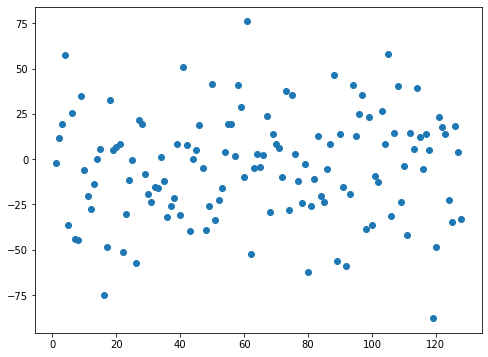

In [43]:
plt.scatter(x_axis1, Lv1_latent[0,2,:])

In [44]:
# Accuracy of VAE

In [45]:
temp4 = Lv1_latent[0,0,:]
temp4.shape

(128,)

In [46]:
temp4 = np.reshape(temp4, [-1, 128])
temp4.shape

(1, 128)

In [47]:
EX = Decoder(temp4) # EX : decoded temp4

In [48]:
print(Lv1_input.shape)

(2000, 14300, 4)


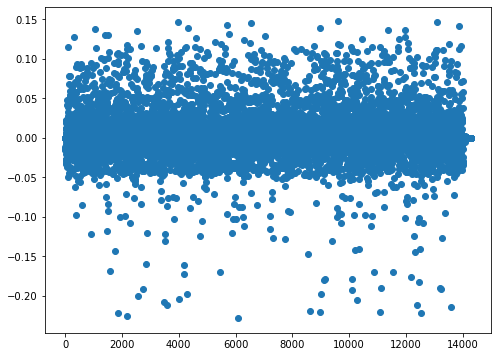

In [49]:
plt.scatter(x_axis, Lv1_input[0,:,0])

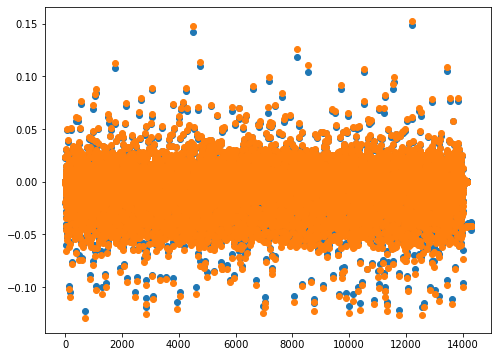

In [50]:
plt.scatter(x_axis, EX[0,:,1])
plt.scatter(x_axis, Lv1_input[0,:,1])

In [51]:
hola = np.zeros([1,14300,4])

hola[0,:,:] = Lv1_input[0,:,:]
print(hola.shape)

(1, 14300, 4)


In [52]:

hola2 = Encoder(hola)
hola3 = Decoder(hola2)

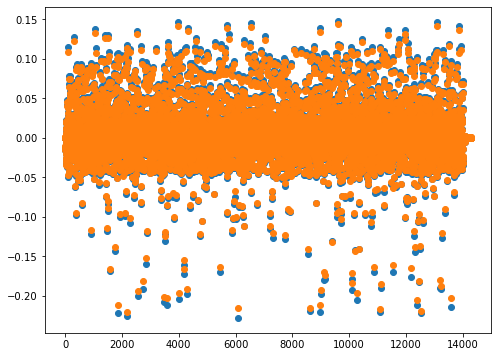

In [53]:
plt.scatter(x_axis, hola[0,:,0])
plt.scatter(x_axis, hola3[0,:,0])

tf.Tensor(
[[[-1.3394004e-02  2.2507582e-02  3.1017055e-06 -7.5462339e-03]
  [ 5.5041164e-05  7.5719459e-04  1.7983690e-06 -7.4580382e-03]
  [-1.0902471e-02 -2.0067213e-02 -2.5682198e-06 -7.3779668e-03]
  ...
  [-1.9560149e-04 -3.9218776e-02 -3.8005057e-06 -7.1282717e-03]
  [ 6.2392908e-04 -3.8276173e-02 -3.7326665e-06 -4.4575119e-03]
  [-1.3983971e-04 -4.5655295e-02 -4.8155935e-06 -4.7508045e-03]]], shape=(1, 14300, 4), dtype=float32)


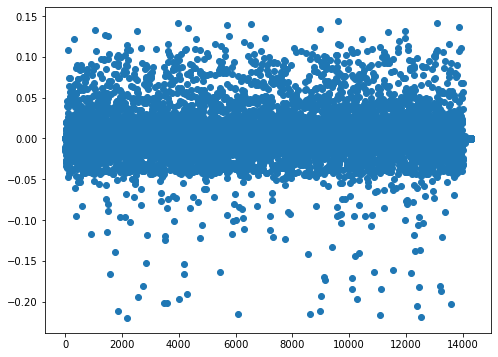

In [54]:
print(hola3)
plt.scatter(x_axis, hola3[0,:,0])

In [ ]:
# FOM_data = (num_param, num_time, num_node, num_var)

x_axis1 = np.linspace(1,200,200)
plt.scatter(x_axis1, FOM_data[5,:,0,3])

# Output latent vectors to file,

In [55]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [56]:
pause;

NameError: name 'pause' is not defined